In [301]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from umap import UMAP
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import math
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
import datetime
from minisom import MiniSom

# Custom models
from utils import (
    scattermapbox,
    plot_cluster_info,
    plot_cluster_size,
    plot_dendrogram,
    plot_kdes
)

# Load pre-processed data
customer_info = pd.read_csv('customer_info_preprocessed.csv', index_col=0)

## K Means

### Scale Data

In [302]:
num=customer_info.select_dtypes(include=['float64']).columns
bool=customer_info.select_dtypes(include=['int64']).columns
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(customer_info[num])
scaled_data = pd.DataFrame(scaled_data, columns=num, index=customer_info.index)
scaled_data

,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,lifetime_spend_alcohol_drinks,...,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,latitude,longitude,customer_age
customer_id,,,,,,,,,,,,,,,,,,,,,
29930,0.2,0.50,0.25,0.333333,0.061455,0.232790,0.388889,0.239669,0.610935,0.382817,...,0.544435,0.157404,0.228842,0.476031,0.641667,0.081279,0.741935,0.228676,0.592676,0.483871
6813,0.0,0.25,0.00,0.333333,0.068273,0.001413,0.444444,0.261488,0.064209,0.032533,...,0.099223,0.135658,0.041203,0.250836,0.120000,0.628728,0.580645,0.366705,0.335161,0.935484
39451,0.2,0.75,0.00,0.666667,0.123131,0.177669,0.444444,0.523636,0.622378,0.590967,...,0.566580,0.317225,0.185969,0.212932,0.530000,0.052019,0.516129,0.929737,0.446683,0.209677
21557,0.0,0.00,0.25,0.000000,0.106047,0.680288,0.444444,0.008926,0.170375,0.585597,...,0.225482,0.047635,0.377506,0.299889,0.366667,0.133099,0.451613,0.443424,0.361135,0.419355
16415,0.1,0.25,0.25,0.444444,0.388623,0.132857,0.444444,0.084959,0.460903,0.172457,...,0.428818,0.360718,0.061804,0.159420,0.405000,0.162735,0.548387,0.916801,0.432151,0.580645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37071,0.1,0.25,0.00,0.111111,0.491766,0.218199,0.555556,0.268430,0.335029,0.481049,...,0.484901,0.361408,0.210468,0.286511,0.270000,0.083118,0.741935,0.539994,0.739911,0.048387
27422,0.1,0.25,0.00,0.222222,0.126911,0.157757,0.388889,0.165620,0.474889,0.218888,...,0.163072,0.327235,0.145880,0.354515,0.630000,0.314483,0.774194,0.477819,0.296972,0.290323
39540,0.1,0.00,0.25,0.111111,0.115445,0.365106,0.611111,0.132562,0.165925,0.152558,...,0.423066,0.126683,0.447105,0.121516,0.378333,0.274256,0.741935,0.722674,0.275287,0.032258


### Select number of  clusters

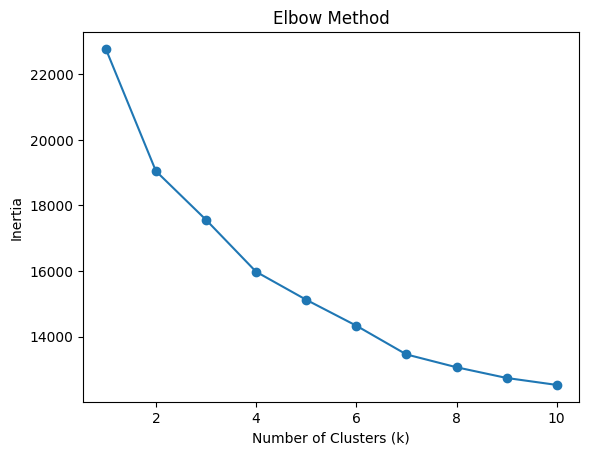

In [303]:
inertia = []
for k in range(1, 11):  # Test k from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

The silhouette score takes very long to execute but gives these results:  
For k=2, Silhouette Score=0.15654165445120632  
For k=3, Silhouette Score=0.15663437064064695  
For k=4, Silhouette Score=0.15316427659771206  
For k=5, Silhouette Score=0.1557186340510429  
For k=6, Silhouette Score=0.1498662720401474  
For k=7, Silhouette Score=0.15666229299748013  
For k=8, Silhouette Score=0.15171614943423709  
For k=9, Silhouette Score=0.14839215311450452  
For k=10, Silhouette Score=0.13479379936826721  

In [304]:
# from sklearn.metrics import silhouette_score
# for k in range(2, 11):  # Silhouette score requires at least 2 clusters
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     kmeans.fit(scaled_data)
#     score = silhouette_score(scaled_data, kmeans.labels_)
#     print(f'For k={k}, Silhouette Score={score}')

Through the elbow method we can assume 6 or 7 clusters are the best option. Also, we saw that for k=7, Silhouette Score is the highest of all tested, therefore, we will try 7 clusters based on the Silhouette Score and elbow method.

### Apply

In [305]:
kmeans = KMeans(n_clusters=7, random_state=42)  
kmeans.fit(scaled_data)  

KMeans(n_clusters=7, random_state=42)

In [306]:
print(kmeans.cluster_centers_)

[[0.12144715 0.20182076 0.33069284 0.17088358 0.0931299  0.04988335
  0.32009143 0.09465685 0.13878336 0.1803271  0.21918112 0.12919953
  0.14322389 0.10126876 0.29602761 0.11254591 0.30967417 0.75328568
  0.47746044 0.38197121 0.13925354]
 [0.09958458 0.07817909 0.17984076 0.24083904 0.08314291 0.08250232
  0.43513604 0.65574539 0.251364   0.1272121  0.01948153 0.03065292
  0.24356607 0.11055249 0.27326697 0.13281175 0.05285723 0.63243078
  0.50416946 0.38308623 0.53520618]
 [0.05431894 0.24247301 0.19321013 0.32479697 0.08413661 0.02370426
  0.47470238 0.15424762 0.10495055 0.05765696 0.29316924 0.10122123
  0.1449008  0.10575827 0.34012646 0.08916321 0.35616068 0.62893179
  0.50909048 0.37821812 0.64235479]
 [0.09801572 0.23727898 0.27431238 0.30447501 0.24179083 0.13140017
  0.41242087 0.10836688 0.431656   0.21728713 0.36458651 0.27074053
  0.41394471 0.17164546 0.38519908 0.40805272 0.22882079 0.54680905
  0.50463953 0.37712393 0.56609101]
 [0.31344146 0.50288963 0.21495153 0.237

In [307]:
print(kmeans.labels_)

[4 2 4 ... 5 3 0]


In [308]:
scaled_data['kmeans_cluster'] = kmeans.labels_

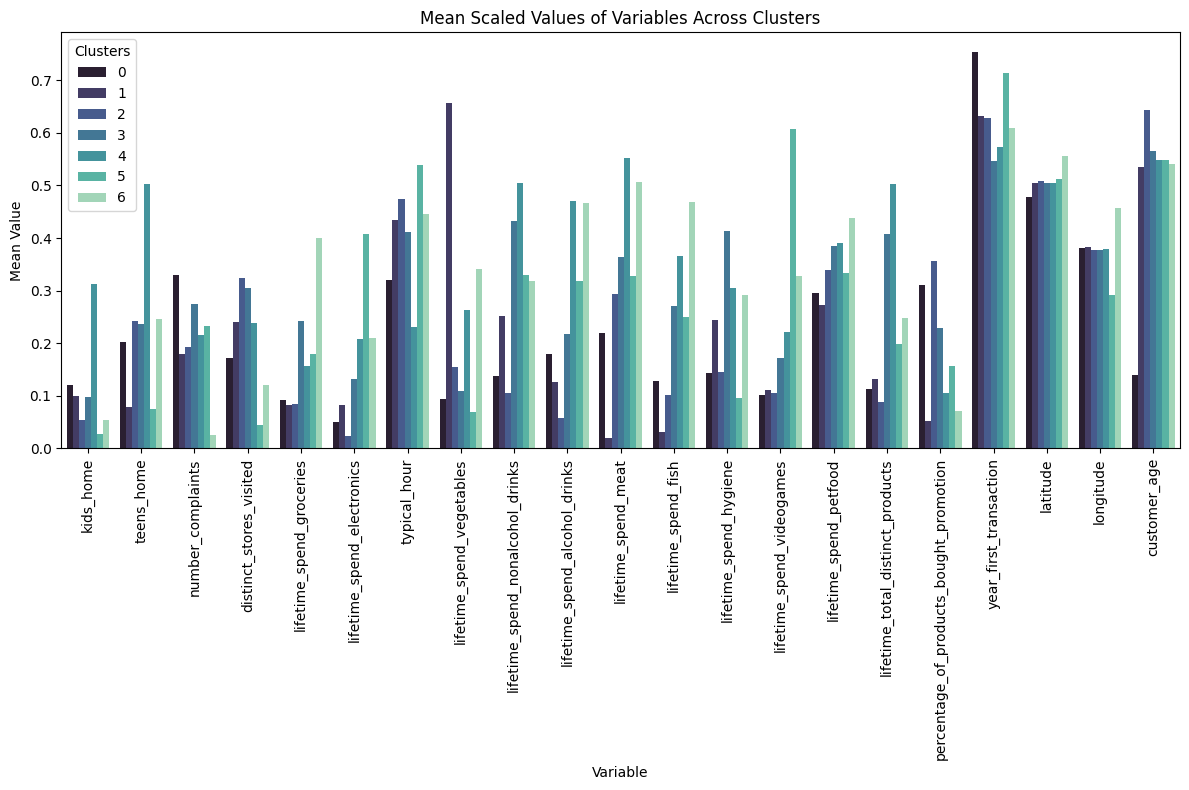

In [309]:
plot_cluster_info(scaled_data,'kmeans_cluster')

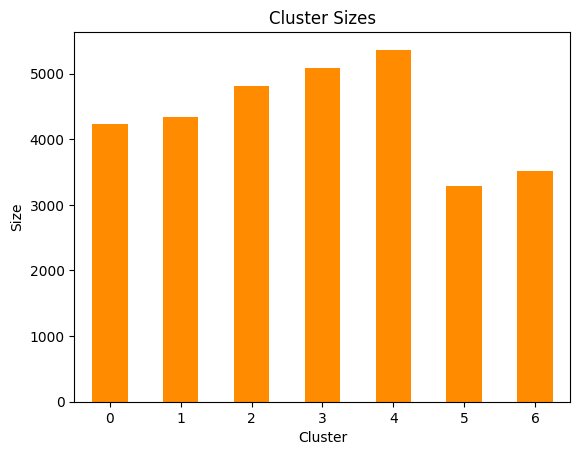

In [310]:
plot_cluster_size(scaled_data,'kmeans_cluster')

**Cluster 1** stands out for its significant spends on vegetables and little to no spend on meat and fish. Can be segmented as **Vegetarians**.

**Cluster 5** has the highest lifetime spent on electronics and videogames, with average values on other variables. Can be segmented as **Tech-Savvy Buyers**.

**Cluster 4** stands out for having a lot of kids and teens at home, which corresponds to significantly high spending on most product categories. Can be segmented as **Large Family Households**.

**Cluster 0** stands out for being the youngest of all, with a lot of complaints and average spending on most variables. A lot of products are bought on promotion. Can be segmented as **Young Promo-Sensitive**.

**Cluster 6** stands out for its consistently high spending across almost all product categories, especially groceries, meat, fish, hygiene, and pet-related items. They also purchase a wide variety of products. Can be segmented as **High-Spending Shoppers**.


## Hierarchical Clustering

### Single Method

In [311]:
minimum_hierarchical = AgglomerativeClustering(
    linkage='single', distance_threshold=0, n_clusters=None
    ).fit(scaled_data)

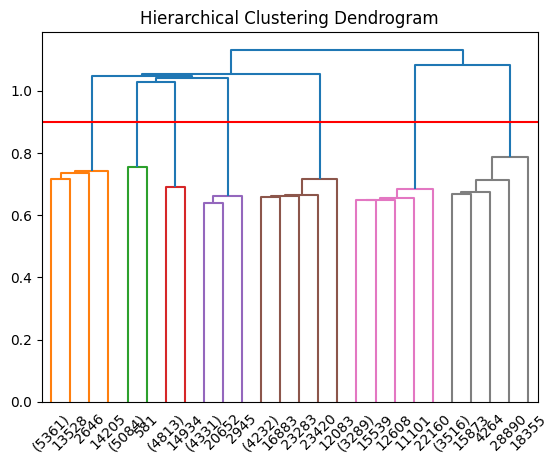

In [312]:
fig, ax = plt.subplots()
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(minimum_hierarchical, truncate_mode="level", p=5)
plt.axhline(y = 0.9, color = 'r', linestyle = '-')
plt.show()

In [313]:
single_prediction = scaled_data.drop(columns=['kmeans_cluster'])
single_prediction['cluster_single'] = AgglomerativeClustering(
    linkage='single', n_clusters=7
    ).fit_predict(scaled_data)

In [314]:
single_prediction.groupby(['cluster_single']).mean()

,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,lifetime_spend_alcohol_drinks,...,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,latitude,longitude,customer_age
cluster_single,,,,,,,,,,,,,,,,,,,,,
0,0.054460,0.245384,0.025710,0.121465,0.399453,0.210522,0.445597,0.340447,0.317451,0.466223,...,0.468965,0.290936,0.328005,0.438047,0.248525,0.070524,0.609256,0.555183,0.457134,0.540295
1,0.313423,0.502843,0.214998,0.237861,0.157495,0.207546,0.230891,0.262736,0.503821,0.470461,...,0.365906,0.305317,0.222335,0.391278,0.503497,0.106000,0.573795,0.504903,0.379106,0.548315
2,0.098053,0.237414,0.273943,0.304796,0.241773,0.131381,0.412389,0.108310,0.431843,0.217373,...,0.270612,0.414144,0.171676,0.385177,0.408202,0.228857,0.546725,0.504610,0.377197,0.565718
3,0.121294,0.201900,0.330441,0.171362,0.093057,0.049833,0.320349,0.094747,0.138703,0.180117,...,0.129113,0.143130,0.101271,0.296207,0.112495,0.309871,0.753351,0.477469,0.381928,0.139423
4,0.054383,0.242366,0.193706,0.324401,0.084325,0.023794,0.474819,0.154227,0.105133,0.057760,...,0.101480,0.145022,0.105762,0.340069,0.089227,0.355878,0.628684,0.509084,0.378176,0.643188
5,0.099585,0.078179,0.179841,0.240839,0.083143,0.082502,0.435136,0.655745,0.251364,0.127212,...,0.030653,0.243566,0.110552,0.273267,0.132812,0.052857,0.632431,0.504169,0.383086,0.535206
6,0.027483,0.074552,0.233450,0.044573,0.178966,0.407657,0.538195,0.068977,0.329941,0.317456,...,0.249143,0.095658,0.606659,0.332753,0.197716,0.156417,0.714301,0.511471,0.291077,0.549073


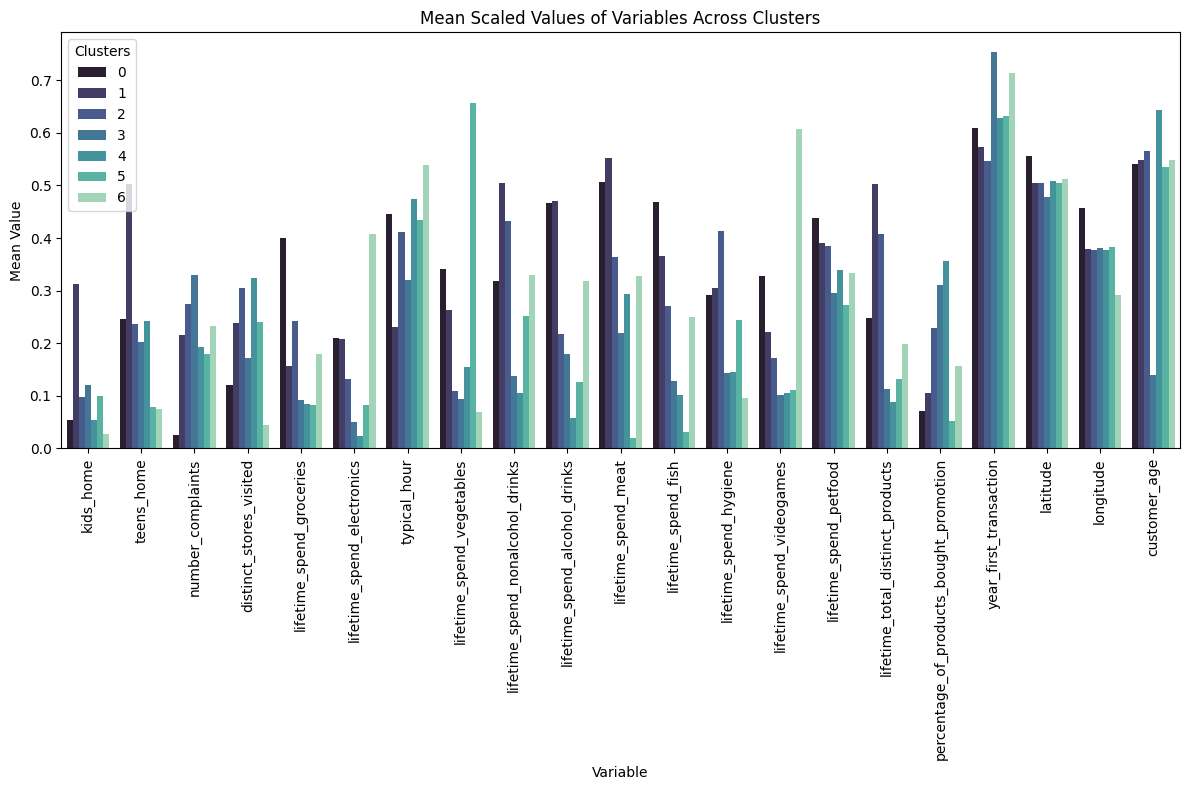

In [315]:
plot_cluster_info(single_prediction,'cluster_single')

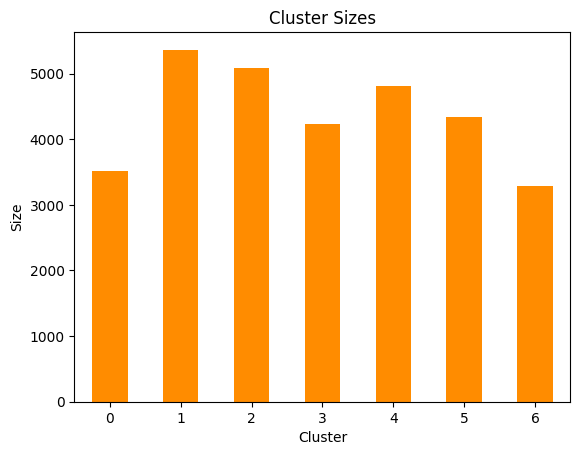

In [316]:
plot_cluster_size(single_prediction,'cluster_single')

We can still see the 5 clusters mentioned in kmeans (Vegeterians, Tech-Savvy Buyers, Large Family Households, Young Promo-Sensitive and High-Spending Shoppers). We will assign them their segment and continue the clustering without these groups.

In [317]:
scaled_data.loc[scaled_data['kmeans_cluster'] == 1, 'kmeans_cluster'] = 'Vegetarians'
scaled_data.loc[scaled_data['kmeans_cluster'] == 5, 'kmeans_cluster'] = 'Tech-Savvy Buyers'
scaled_data.loc[scaled_data['kmeans_cluster'] == 4, 'kmeans_cluster'] = 'Large Family Households'
scaled_data.loc[scaled_data['kmeans_cluster'] == 0, 'kmeans_cluster'] = 'Young Promo-Sensitive'
scaled_data.loc[scaled_data['kmeans_cluster'] == 6, 'kmeans_cluster'] = 'High-Spending Shoppers'
customer_info['segmentation'] = scaled_data['kmeans_cluster']

C:\Users\User\AppData\Local\Temp\ipykernel_11620\1496533055.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Vegetarians' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  scaled_data.loc[scaled_data['kmeans_cluster'] == 1, 'kmeans_cluster'] = 'Vegetarians'


In [318]:
customer_info['segmentation'].value_counts()

segmentation
Large Family Households    5364
3                          5085
2                          4814
Vegetarians                4333
Young Promo-Sensitive      4236
High-Spending Shoppers     3520
Tech-Savvy Buyers          3293
Name: count, dtype: int64

We will continue to work with this dataset:

In [319]:
scaled_data2 = scaled_data[scaled_data['kmeans_cluster'].isin([2, 3])]
scaled_data2

,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,lifetime_spend_alcohol_drinks,...,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,latitude,longitude,customer_age,kmeans_cluster
customer_id,,,,,,,,,,,,,,,,,,,,,
6813,0.0,0.25,0.00,0.333333,0.068273,0.001413,0.444444,0.261488,0.064209,0.032533,...,0.135658,0.041203,0.250836,0.120000,0.628728,0.580645,0.366705,0.335161,0.935484,2
16415,0.1,0.25,0.25,0.444444,0.388623,0.132857,0.444444,0.084959,0.460903,0.172457,...,0.360718,0.061804,0.159420,0.405000,0.162735,0.548387,0.916801,0.432151,0.580645,3
13243,0.1,0.00,0.25,0.333333,0.050408,0.031510,0.388889,0.098512,0.059123,0.053064,...,0.382119,0.133073,0.386845,0.185000,0.550346,0.774194,0.513462,0.487702,0.741935,2
39157,0.1,0.25,0.00,0.444444,0.151302,0.008356,0.388889,0.124959,0.075016,0.065382,...,0.060062,0.145880,0.208473,0.096667,0.466073,0.612903,0.531891,0.169535,0.435484,2
28504,0.1,0.25,0.25,0.444444,0.309453,0.093656,0.166667,0.151074,0.272092,0.077701,...,0.533310,0.266147,0.232999,0.275000,0.308004,0.387097,0.403921,0.433900,0.741935,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25292,0.0,0.25,0.50,0.333333,0.116929,0.013926,0.000000,0.212893,0.084552,0.049905,...,0.053158,0.169265,0.400223,0.103333,0.383067,0.741935,0.519868,0.503171,0.822581,2
6000,0.1,0.00,0.25,0.333333,0.077750,0.117767,0.444444,0.044298,0.263191,0.261845,...,0.232309,0.137528,0.332219,0.411667,0.122835,0.548387,0.377384,0.237138,0.354839,3
11347,0.2,0.00,0.25,0.333333,0.194015,0.146658,0.444444,0.080661,0.340114,0.239103,...,0.587159,0.159800,0.365663,0.131667,0.403642,0.387097,0.572723,0.624151,0.564516,3


## 2nd K-Means

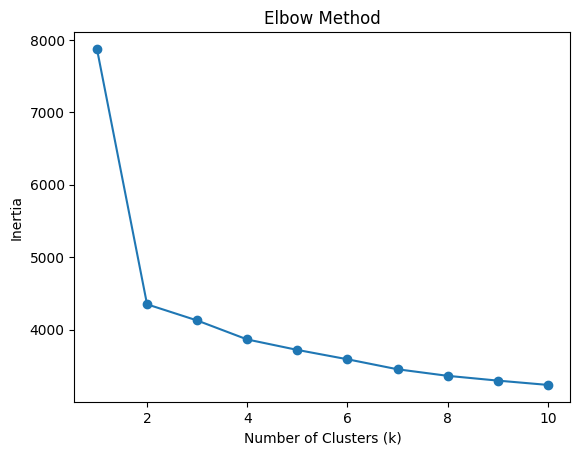

In [320]:
inertia = []
for k in range(1, 11):  # Test k from 1 to 10
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data2)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [321]:
kmeans = KMeans(n_clusters=2, random_state=42)  
kmeans.fit(scaled_data2) 

KMeans(n_clusters=2, random_state=42)

In [322]:
scaled_data2['kmeans_cluster'] = kmeans.labels_

C:\Users\User\AppData\Local\Temp\ipykernel_11620\3440005954.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_data2['kmeans_cluster'] = kmeans.labels_


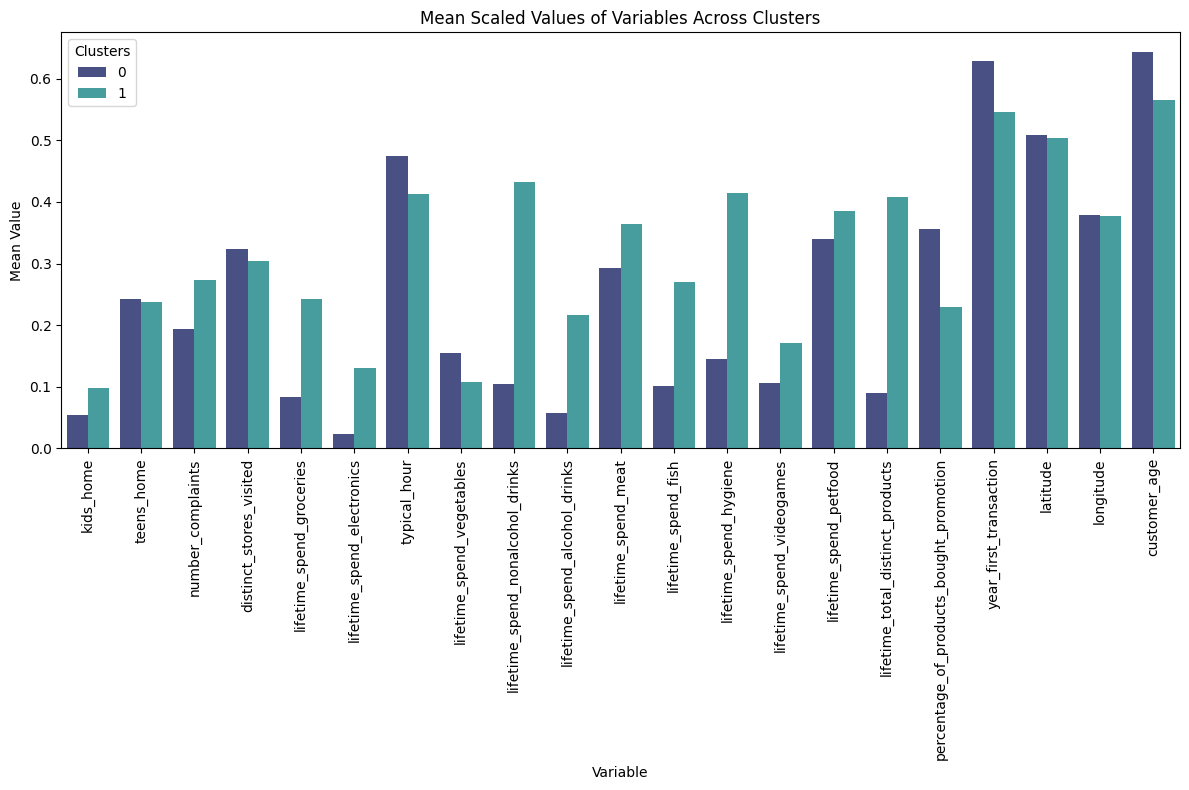

In [323]:
plot_cluster_info(scaled_data2,'kmeans_cluster')

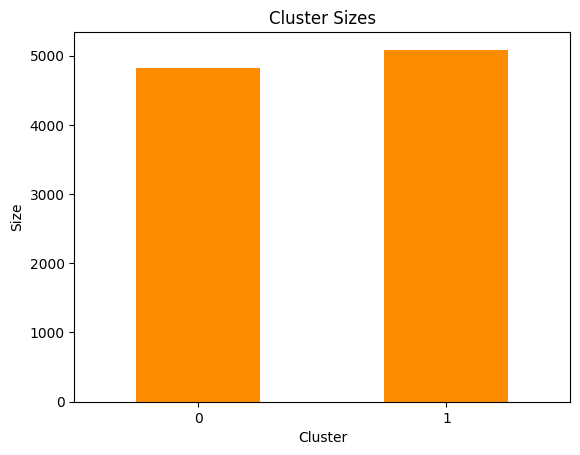

In [324]:
plot_cluster_size(scaled_data2, 'kmeans_cluster')

## 2nd Hierarchical Clustering

In [325]:
minimum_hierarchical = AgglomerativeClustering(
    linkage='single', distance_threshold=0, n_clusters=None
    ).fit(scaled_data2)

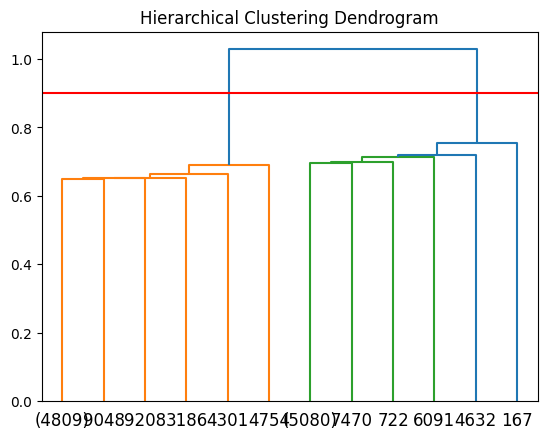

In [326]:
fig, ax = plt.subplots()
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(minimum_hierarchical, truncate_mode="level", p=5)
plt.axhline(y = 0.9, color = 'r', linestyle = '-')
plt.show()

In [327]:
single_prediction2 = scaled_data2.drop(columns=['kmeans_cluster'])
single_prediction2['cluster_single'] = AgglomerativeClustering(
    linkage='single', n_clusters=2
    ).fit_predict(scaled_data2)

In [328]:
single_prediction2.groupby(['cluster_single']).mean()

,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,lifetime_spend_alcohol_drinks,...,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,latitude,longitude,customer_age
cluster_single,,,,,,,,,,,,,,,,,,,,,
0,0.098053,0.237414,0.273943,0.304796,0.241773,0.131381,0.412389,0.108310,0.431843,0.217373,...,0.270612,0.414144,0.171676,0.385177,0.408202,0.228857,0.546725,0.504610,0.377197,0.565718
1,0.054383,0.242366,0.193706,0.324401,0.084325,0.023794,0.474819,0.154227,0.105133,0.057760,...,0.101480,0.145022,0.105762,0.340069,0.089227,0.355878,0.628684,0.509084,0.378176,0.643188


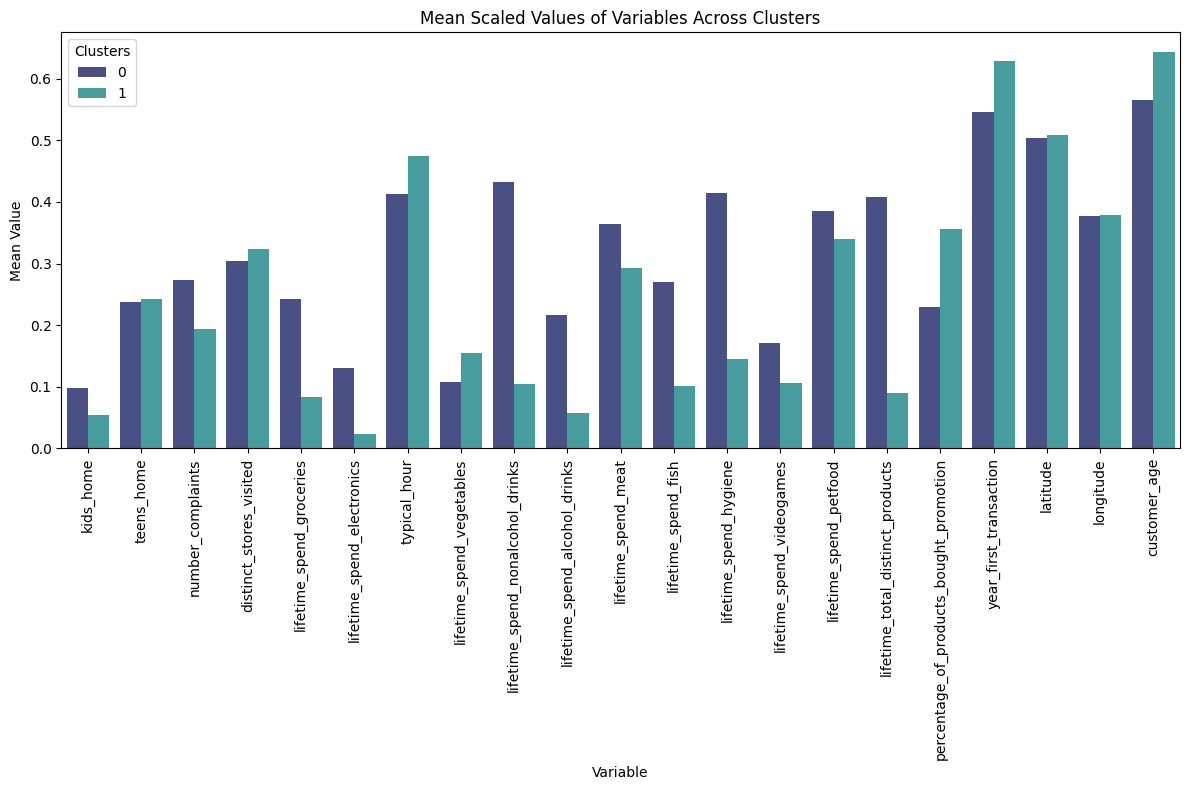

In [329]:
plot_cluster_info(single_prediction2,'cluster_single')

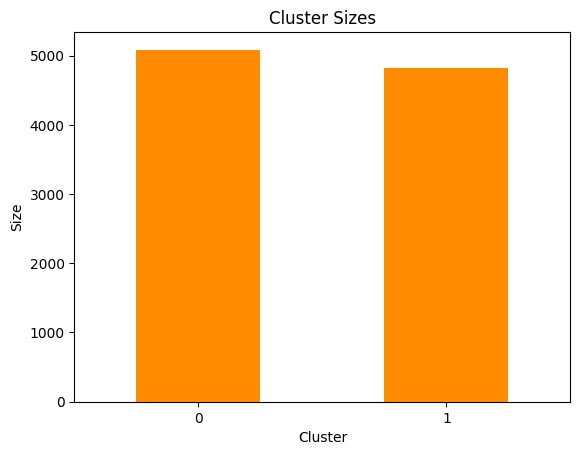

In [330]:
plot_cluster_size(single_prediction2,'cluster_single')

### KDEs Plots for KMeans Clusters vs Rest

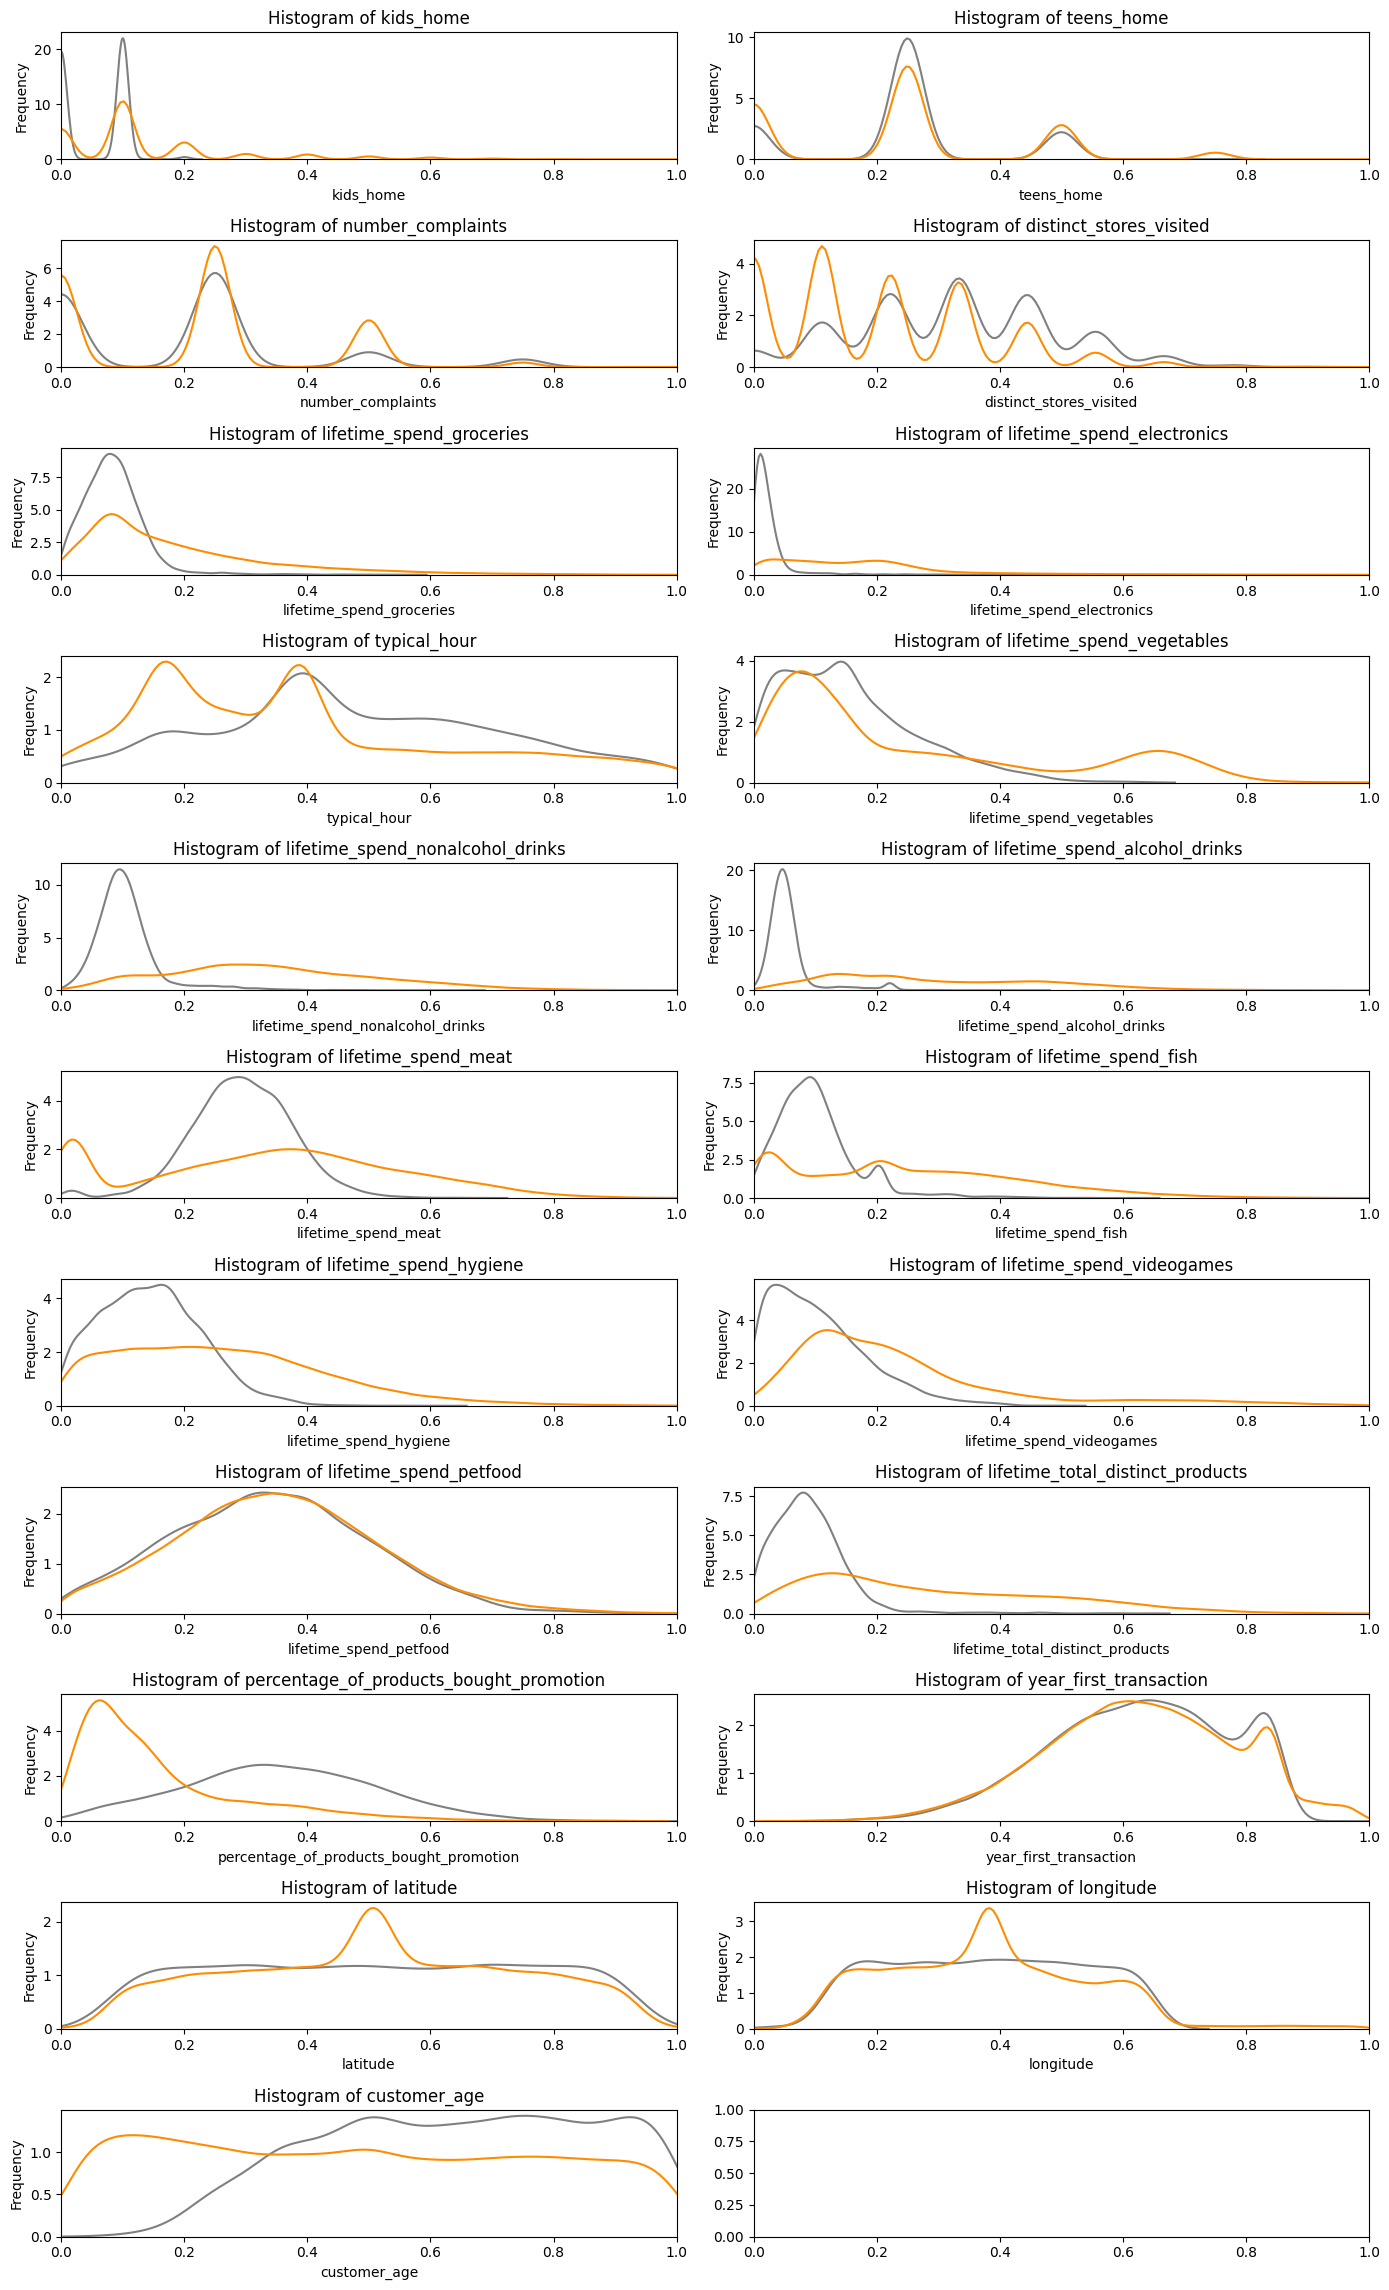

In [331]:
index0 = scaled_data2[scaled_data2['kmeans_cluster'] == 0].index
# Plot KDEs for the cluster = 0
plot_kdes(
    scaled_data2[scaled_data2['kmeans_cluster'] == 0].drop('kmeans_cluster', axis=1),
    scaled_data.drop(index=index0)
)

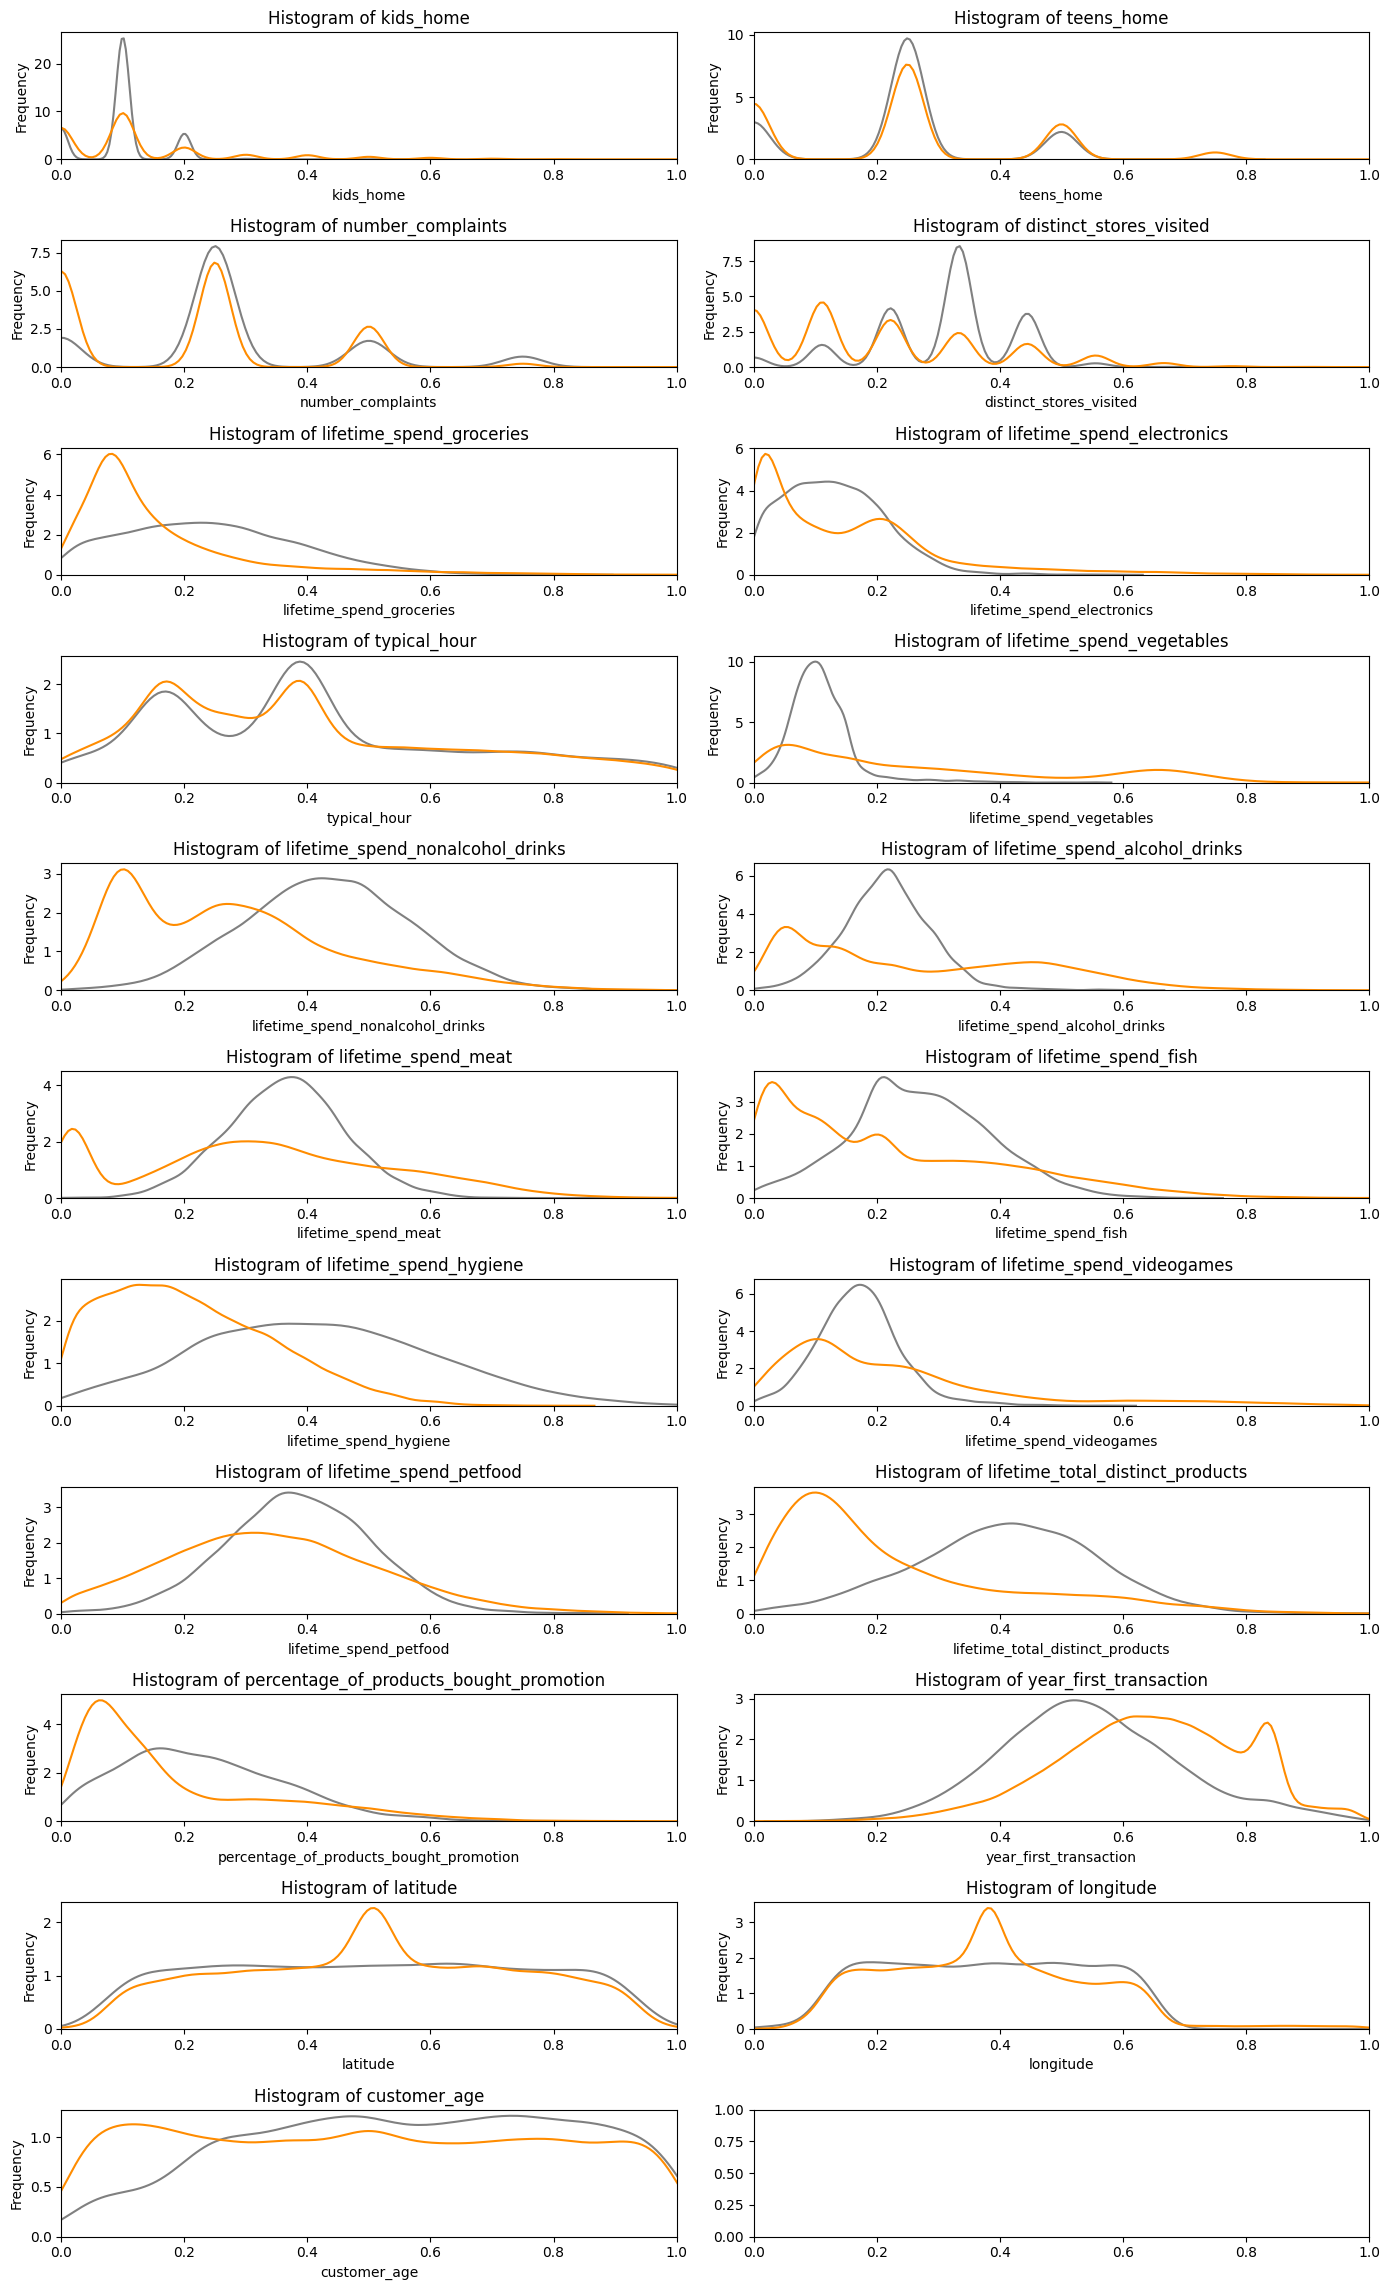

In [332]:
index1 = scaled_data2[scaled_data2['kmeans_cluster'] == 1].index
# Plot KDEs for the cluster = 1
plot_kdes(
    scaled_data2[scaled_data2['kmeans_cluster'] == 1].drop('kmeans_cluster', axis=1),
    scaled_data.drop(index=index1)
)

## DBScan

In [333]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

dbscan = DBSCAN(eps=0.5, min_samples=5)
scaled_data2['dbscan_cluster'] = dbscan.fit_predict(scaled_data2)


C:\Users\User\AppData\Local\Temp\ipykernel_11620\1557858512.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_data2['dbscan_cluster'] = dbscan.fit_predict(scaled_data2)


In [334]:
mask = scaled_data2['dbscan_cluster'] != -1
if mask.sum() > 1:
    silhouette = silhouette_score(scaled_data2[mask].drop(columns=['dbscan_cluster']), scaled_data2.loc[mask, 'dbscan_cluster'])
    print(f'Silhouette Score DBSCAN (no -1): {silhouette:.4f}')
else:
    print("Too few clustered samples to compute silhouette score.")


Silhouette Score DBSCAN (no -1): 0.4061


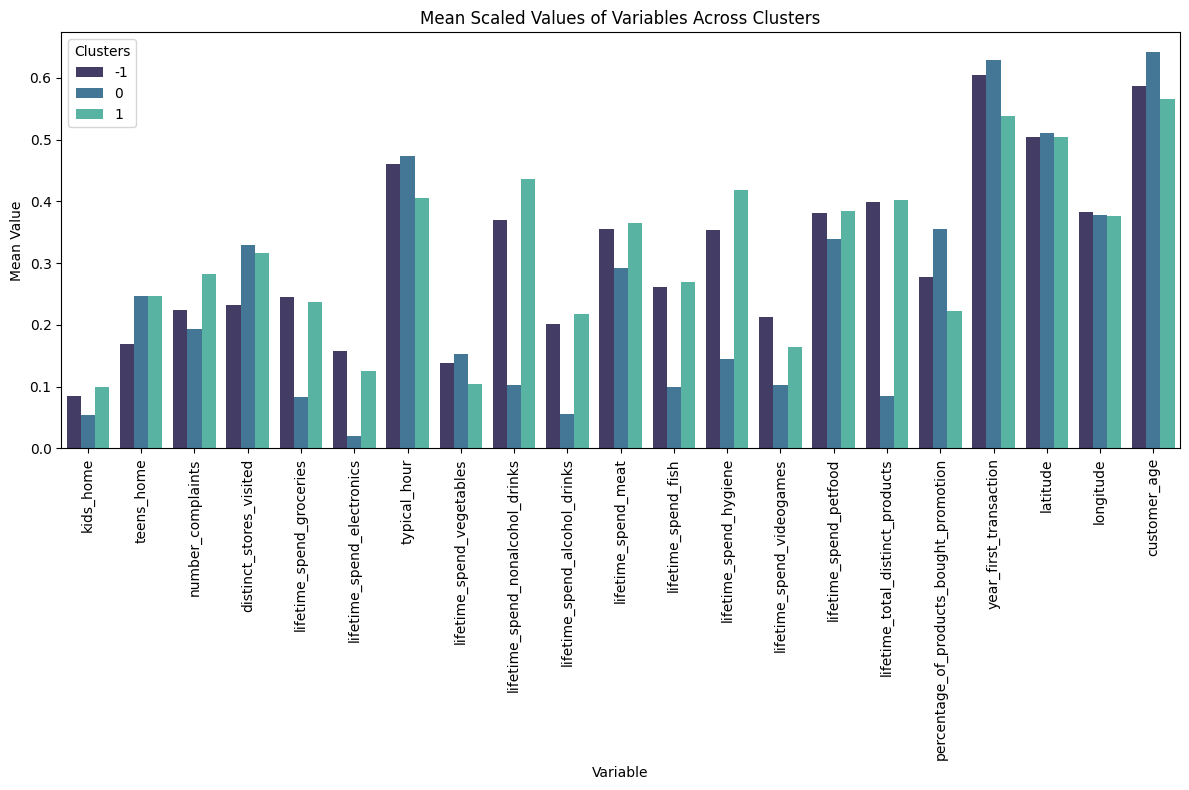

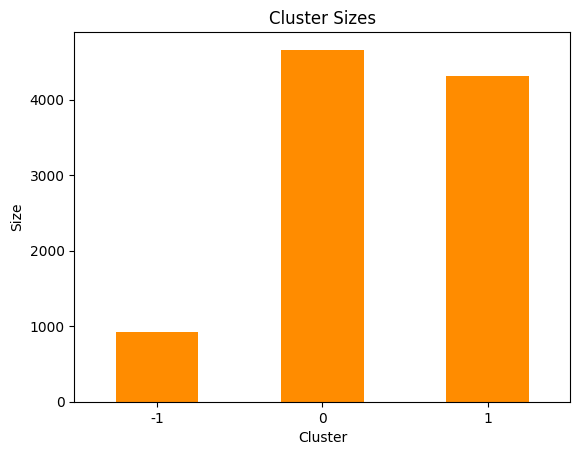

,kids_home,teens_home,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,lifetime_spend_alcohol_drinks,...,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_spend_petfood,lifetime_total_distinct_products,percentage_of_products_bought_promotion,year_first_transaction,latitude,longitude,customer_age
dbscan_cluster,,,,,,,,,,,,,,,,,,,,,
-1,0.084691,0.169110,0.224213,0.231512,0.245762,0.158310,0.460068,0.139086,0.369835,0.201879,...,0.261059,0.354202,0.213046,0.381406,0.398771,0.278305,0.603972,0.504681,0.383367,0.587090
0,0.054600,0.247158,0.193330,0.329020,0.082550,0.020364,0.473658,0.153310,0.103029,0.055559,...,0.099111,0.144184,0.102309,0.339585,0.085676,0.355428,0.628289,0.510151,0.377949,0.641633
1,0.099143,0.246987,0.282155,0.316132,0.237330,0.125575,0.405652,0.104340,0.435919,0.217474,...,0.269292,0.418426,0.164271,0.384925,0.402889,0.223234,0.537801,0.503599,0.376159,0.565548


In [335]:
plot_data = scaled_data2.drop(columns=['kmeans_cluster'])

plot_cluster_info(plot_data, 'dbscan_cluster') 
plot_cluster_size(plot_data, 'dbscan_cluster')
plot_data.groupby('dbscan_cluster').mean()


**2nd K-Means Segmentation**  
**Cluster 0** has the highest average age among all groups. They tend to spend less overall and are highly attentive to promotions. Their shopping behavior reflects cautious and price-sensitive habits. Can be segmented as **Promo-Oriented Seniors**.

**Cluster 1** stands out for spending more than the others, with consistently high values across many categories. They purchase a broad mix of products and show little interest in promotions. Can be segmented as **Wide-Range Shoppers**.



In [336]:
refined_labels = {
    2: 'Promo-Oriented Seniors',
    3: 'Wide-Range Shoppers',
}

scaled_data['kmeans_cluster'] = scaled_data['kmeans_cluster'].apply(
    lambda x: refined_labels[x] if x in refined_labels else x
)


In [337]:
customer_info['segmentation'] = scaled_data['kmeans_cluster']

In [339]:
customer_info_backup = pd.read_csv("customer_info_backup.csv")


In [340]:
customer_info_backup = customer_info_backup.set_index('customer_id')

In [342]:
# Addigng the geo-cluster based on latitude and longitude
geo_cluster = customer_info_backup[
    (customer_info_backup['latitude'].between(38.7221, 38.7240)) &
    (customer_info_backup['longitude'].between(-9.2148, -9.2130))
]

In [343]:
geo_cluster['segmentation'] = 'Alfragide'

C:\Users\User\AppData\Local\Temp\ipykernel_11620\3200040115.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geo_cluster['segmentation'] = 'Alfragide'


In [344]:
customer_info = pd.concat([customer_info, geo_cluster], ignore_index=False)

In [346]:
customer_info['segmentation'].value_counts()

segmentation
Large Family Households    5364
Wide-Range Shoppers        5085
Promo-Oriented Seniors     4814
Vegetarians                4333
Young Promo-Sensitive      4236
High-Spending Shoppers     3520
Tech-Savvy Buyers          3293
Alfragide                    88
Name: count, dtype: int64

### Results

In [347]:
customer_info['segmentation']

customer_id
29930    Large Family Households
6813      Promo-Oriented Seniors
39451    Large Family Households
21557          Tech-Savvy Buyers
16415        Wide-Range Shoppers
                  ...           
9629                   Alfragide
24185                  Alfragide
10075                  Alfragide
7703                   Alfragide
459                    Alfragide
Name: segmentation, Length: 30733, dtype: object

In [348]:
# Saving 1st clustering checkpoint
customer_info[['segmentation']].to_csv('1st_clustering_results.csv')

## UMAP First Clustering Results (Scaled)

In [350]:
customer_info = customer_info.dropna()

X = customer_info.drop(columns=['segmentation'])
num_cols = X.select_dtypes(include=['float64']).columns
int_cols = X.select_dtypes(include=['int64']).columns
X = X[num_cols.union(int_cols)]

In [351]:
scaler = MinMaxScaler(feature_range=(0, 1)) 
X_scaled = scaler.fit_transform(X[num_cols])
X_scaled = pd.DataFrame(X_scaled, columns=num_cols, index=customer_info.index)

y = customer_info['segmentation']

In [352]:
umap_model = UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)

df_umap = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'])
df_umap['Cluster'] = y.values


c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


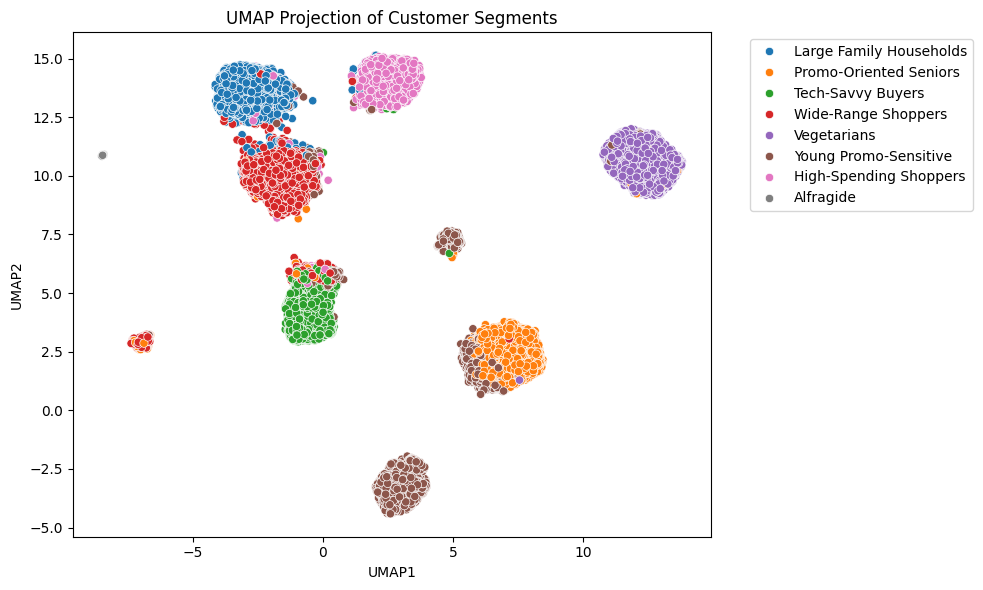

In [353]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_umap, x='UMAP1', y='UMAP2', hue='Cluster', palette='tab10')
plt.title('UMAP Projection of Customer Segments')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Validation tests

In [354]:
score = silhouette_score(X_umap, df_umap['Cluster'])
print(f"Silhouette Score on UMAP projection: {score:.4f}")


Silhouette Score on UMAP projection: 0.5481


A Silhouette score > 0.5 (higher the better) Indicates Strong Structure

In [355]:
from sklearn.metrics import davies_bouldin_score

db_index = davies_bouldin_score(X_umap, df_umap['Cluster'])
print(f"Davies-Bouldin Index on UMAP projection: {db_index:.4f}")

Davies-Bouldin Index on UMAP projection: 0.8822


A David-Bouldin Index < 1.0 (the lower the better) Indicates Good Separation

## Conclusion

The validation tests and the UMAP suggest we have a good segmentation done. We saved this segmentation as 1st_clustering_results.csv